In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q requests beautifulsoup4 pandas underthesea nltk transformers torch tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [16]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import os
import random
import json
from urllib.parse import urljoin
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import matplotlib
plt.rcParams['font.family'] = 'DejaVu Sans'

In [5]:
class GenkAPICollector:
    def __init__(self):
        self.categories = {
            # "ai": {"url": "https://genk.vn/ajax-cate/page-{page}-c253.chn", "name": "AI"},
            "gia-dung": {"url": "https://genk.vn/ajax-cate/page-{page}-c245.chn", "name": "Gia dụng"},
            "xe": {"url": "https://genk.vn/ajax-cate/page-{page}-c251.chn", "name": "Xe"},
            "kham-pha": {"url": "https://genk.vn/ajax-cate/page-{page}-c198.chn", "name": "Khám phá"},
            "mobile": {"url": "https://genk.vn/ajax-cate/page-{page}-c187.chn", "name": "Mobile"},
            "apps-games": {"url": "https://genk.vn/ajax-cate/page-{page}-c193.chn", "name": "Apps-Games"},
            # "internet": {"url": "https://genk.vn/ajax-cate/page-{page}-c220.chn", "name": "Internet"},
            # "do-choi-so": {"url": "https://genk.vn/ajax-cate/page-{page}-c188.chn", "name": "Đồ chơi số"},
            # "thu-thuat": {"url": "https://genk.vn/ajax-cate/page-{page}-c186.chn", "name": "Thủ thuật"}
            # "tin-ict": {"url": "https://genk.vn/ajax-cate/page-{page}-c211.chn", "name": "Tin ICT"}
        }
        self.data = []
        self.processed_links = set()


        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
            'Accept-Language': 'vi-VN,vi;q=0.9,en;q=0.8',
            'Accept-Encoding': 'gzip, deflate, br',
            'Connection': 'keep-alive',
            'Upgrade-Insecure-Requests': '1',
            'Referer': 'https://genk.vn/',
            'X-Requested-With': 'XMLHttpRequest'
        }

    def get_articles_from_api(self, category_key, page):
        try:
            api_url = self.categories[category_key]["url"].format(page=page)
            print(f"Đang gọi API: {api_url}")

            response = requests.get(api_url, headers=self.headers, timeout=15)
            response.raise_for_status()

            # Parse HTML từ response
            soup = BeautifulSoup(response.text, 'html.parser')

            # Tìm các bài viết
            articles = []

            # Các selector có thể cho bài viết
            article_selectors = [
                "div.knswli-right",
                "div.story-item",
                "article",
                "div.news-item",
                "div.item-news",
                "div.kbwc-item",
                "div.story",
                "div[class*='item']",
                "div.item"
            ]

            article_elements = []
            for selector in article_selectors:
                elements = soup.select(selector)
                if elements:
                    article_elements = elements
                    print(f"Tìm thấy {len(elements)} bài viết với selector: {selector}")
                    break

            if not article_elements:
                print("Không tìm thấy bài viết trong response")
                return []

            for element in article_elements:
                article_info = self.extract_article_info(element)
                if article_info and article_info.get('link') and article_info['link'] not in self.processed_links:
                    articles.append(article_info)
                    self.processed_links.add(article_info['link'])

            return articles

        except requests.exceptions.RequestException as e:
            print(f"Lỗi khi gọi API trang {page}: {e}")
            return []
        except Exception as e:
            print(f"Lỗi không xác định trang {page}: {e}")
            return []

    def extract_article_info(self, article_element):
        try:
            # Tìm title và link
            title_selectors = [
                "h4.knswli-title a",
                "h3 a",
                "h2 a",
                "h1 a",
                "a[class*='title']",
                ".title a",
                "a"
            ]

            title_element = None
            for sel in title_selectors:
                title_element = article_element.select_one(sel)
                if title_element:
                    break

            if not title_element:
                return None

            title = title_element.get_text(strip=True)
            link = title_element.get('href', '')

            if link.startswith('/'):
                link = 'https://genk.vn' + link

            summary_selectors = [
                "p.knswli-sapo",
                ".summary",
                ".sapo",
                "p.desc",
                "div.sapo-box p",
                "div.article-summary p",
                "p",
                ".description"
            ]
            summary = ""
            for sel in summary_selectors:
                summary_element = article_element.select_one(sel)
                if summary_element:
                    summary = summary_element.get_text(strip=True)
                    if summary:
                         break


            return {
                'title': title,
                'link': link,
                'summary': summary
            }

        except Exception as e:
            print(f"Lỗi khi trích xuất thông tin bài viết: {e}")
            return None

    def get_article_detail(self, article_info, category_name):
        try:
            print(f"Đang lấy chi tiết: {article_info['title'][:50]}...")

            response = requests.get(article_info['link'], headers=self.headers, timeout=15)
            response.raise_for_status()

            soup = BeautifulSoup(response.text, 'html.parser')

            # Lấy nội dung
            content_selectors = [
                "div.kbwc-detail p",
                "div.detail-content p",
                "div.content p",
                "div.article-content p",
                "div.post-content p",
                "div.knc-detail p",
                "div[class*='body-text'] p",
                "div[itemprop='articleBody'] p"
            ]

            content = ""
            for sel in content_selectors:
                content_tags = soup.select(sel)
                if content_tags:
                    content_parts = []
                    for p in content_tags:
                        text = p.get_text(strip=True)
                        if text and len(text) > 10:
                            content_parts.append(text)
                    content = "\n".join(content_parts)
                    break


            if content and len(content) > 100:
                return {
                    "title": article_info['title'],
                    "content": content,
                    "category": category_name,
                }
            else:
                print(f"Nội dung ngắn, bỏ qua bài viết")
                return None

        except Exception as e:
            print(f"Lỗi khi lấy chi tiết bài viết {article_info['link']}: {e}")
            return None

    def crawl_category(self, category_key, target_articles=2000, max_pages=200):
        category_name = self.categories[category_key]["name"]
        print(f"Bắt đầu: {category_name}")

        category_articles = []
        page = 1
        consecutive_empty_pages = 0

        while len(category_articles) < target_articles and page <= max_pages:
            print(f"\nTrang {page}")

            # Lấy danh sách bài viết từ API
            articles_list = self.get_articles_from_api(category_key, page)

            if not articles_list:
                consecutive_empty_pages += 1
                print(f"Trang {page} trống ({consecutive_empty_pages} trang trống liên tiếp)")

                if consecutive_empty_pages >= 5:
                    print("Đã có 5 trang trống liên tiếp")
                    break

                page += 1
                time.sleep(random.uniform(2, 4))
                continue

            consecutive_empty_pages = 0
            print(f"Trang {page}: Tìm thấy {len(articles_list)} bài viết")

            # Lấy chi tiết từng bài viết
            for i, article_info in enumerate(articles_list):
                if len(category_articles) >= target_articles:
                    break

                print(f"  Bài {i+1}/{len(articles_list)} (Đã có: {len(category_articles)}/{target_articles})")

                article_detail = self.get_article_detail(article_info, category_name)

                if article_detail:
                    category_articles.append(article_detail)
                    print(f"Thành công: {article_detail['title'][:50]}")
                else:
                    print(f"Không lấy được chi tiết")

                # Delay giữa các request
                time.sleep(random.uniform(1, 2))

            page += 1

            # Delay giữa các trang
            time.sleep(random.uniform(2, 4))


        print(f"\nHoàn thành {category_name}: {len(category_articles)} bài viết")
        return category_articles

    def collect_all_data(self, min_articles_per_category=900, max_articles_per_category=1000):
        self.data = []

        for category_key in self.categories.keys():
            print(f"\nBắt đầu chủ đề: {self.categories[category_key]['name']}")

            target_articles = random.randint(min_articles_per_category, max_articles_per_category)
            print(f"Mục tiêu thu thập cho chủ đề '{self.categories[category_key]['name']}': {target_articles} bài viết")

            category_articles = self.crawl_category(category_key, target_articles=target_articles)

            if category_articles:
                self.data.extend(category_articles)
                print(f"Đã thêm {len(category_articles)} bài viết từ {self.categories[category_key]['name']}")

            else:
                print(f"Không thu thập được bài viết nào từ {self.categories[category_key]['name']}")

            print(f"Tổng tiến độ: {len(self.data)} bài viết")

            # Delay giữa các chủ đề
            if category_key != list(self.categories.keys())[-1]:
                time.sleep(random.uniform(10, 15))

        print(f"Tổng cộng: {len(self.data)} bài viết")

        # Thống kê chi tiết
        if self.data:
            category_counts = {}
            for article in self.data:
                cat = article['category']
                category_counts[cat] = category_counts.get(cat, 0) + 1

            print("\nThống kê theo chủ đề:")
            for cat, count in category_counts.items():
                print(f"{cat}: {count} bài viết")

        return self.data

    def save_data(self, filename):
        if not self.data:
            print("Không có dữ liệu để lưu!")
            return None

        try:
            df = pd.DataFrame(self.data)
            df = df[['title', 'content', 'category']]

            original_count = len(df)
            df = df.drop_duplicates(subset=['title', 'content'])
            duplicates_removed = original_count - len(df)

            if duplicates_removed > 0:
                 print(f"Đã loại bỏ {duplicates_removed} bài viết trùng lặp dựa trên tiêu đề và nội dung.")


            df.to_csv(filename, index=False, encoding='utf-8')

            print(f"Đã lưu {len(df)} bài viết vào {filename}")
            print(f"Kích thước file: {os.path.getsize(filename):,} bytes")

            return filename

        except Exception as e:
            print(f"Lỗi khi lưu: {e}")
            return None

    def get_statistics(self):
        if not self.data:
            print("Không có dữ liệu để thống kê")
            return

        print(f"THỐNG KÊ CHI TIẾT")

        df = pd.DataFrame(self.data)

        print(f"Tổng số bài viết: {len(df)}")
        print(f"Số chủ đề: {df['category'].nunique()}")

        print(f"\nPhân bố theo chủ đề:")
        category_stats = df['category'].value_counts()
        for category, count in category_stats.items():
            percentage = (count / len(df)) * 100
            print(f"   {category}: {count} bài viết ({percentage:.1f}%)")

In [5]:
save_dir = '/content/drive/MyDrive/KKDL_Project'
collector = GenkAPICollector()

print("Bắt đầu thu thập dữ liệu")

data = collector.collect_all_data(min_articles_per_category=900, max_articles_per_category=1000)

if data:
    final_filename = os.path.join(save_dir, 'genk_data.csv')
    saved_file = collector.save_data(final_filename)

    if saved_file:
        print(f"\nDữ liệu đã lưu tại: {saved_file}")

        collector.get_statistics()

        print(f"\nFile dữ liệu: {saved_file}")
        print(f"Thư mục chứa: {save_dir}")
    else:
        print(f"\nKhông thể lưu dữ liệu!")
else:
    print("\nKhông thu thập được dữ liệu nào!")

Bắt đầu thu thập dữ liệu

Bắt đầu chủ đề: Gia dụng
Mục tiêu thu thập cho chủ đề 'Gia dụng': 973 bài viết
Bắt đầu: Gia dụng

Trang 1
Đang gọi API: https://genk.vn/ajax-cate/page-1-c245.chn
Tìm thấy 28 bài viết với selector: div.knswli-right
Trang 1: Tìm thấy 28 bài viết
  Bài 1/28 (Đã có: 0/973)
Đang lấy chi tiết: Samsung kết hợp DC quảng bá Superman qua TV 115 in...
Thành công: Samsung kết hợp DC quảng bá Superman qua TV 115 in
  Bài 2/28 (Đã có: 1/973)
Đang lấy chi tiết: Người dân nhìn hóa đơn tiền điện tháng 6 mà "sốc":...
Thành công: Người dân nhìn hóa đơn tiền điện tháng 6 mà "sốc":
  Bài 3/28 (Đã có: 2/973)
Đang lấy chi tiết: Điều hòa Mitsubishi Heavy Industries - Công nghệ N...
Thành công: Điều hòa Mitsubishi Heavy Industries - Công nghệ N
  Bài 4/28 (Đã có: 3/973)
Đang lấy chi tiết: Comfee Gusto: Điều hòa AI chủ động làm mát, kiểm s...
Thành công: Comfee Gusto: Điều hòa AI chủ động làm mát, kiểm s
  Bài 5/28 (Đã có: 4/973)
Đang lấy chi tiết: Trên nồi cơm điện có 4 nơi dễ “giấu” 

KeyboardInterrupt: 

Đã đọc file dữ liệu: /content/drive/MyDrive/KKDL_Project/genk_data.csv
Tổng số bài viết trong file: 4661
Các cột: ['title', 'content', 'category']
Phân bố theo chủ đề:
category
Xe            991
Apps-Games    970
Mobile        937
Khám phá      929
Gia dụng      834
Name: count, dtype: int64

Phân bố theo chủ đề:
   Xe: 991 bài viết (21.3%)
   Apps-Games: 970 bài viết (20.8%)
   Mobile: 937 bài viết (20.1%)
   Khám phá: 929 bài viết (19.9%)
   Gia dụng: 834 bài viết (17.9%)

Thống kê độ dài nội dung:
   Độ dài nội dung trung bình: 3652 ký tự
   Độ dài nội dung ngắn nhất: 140 ký tự
   Độ dài nội dung dài nhất: 23131 ký tự


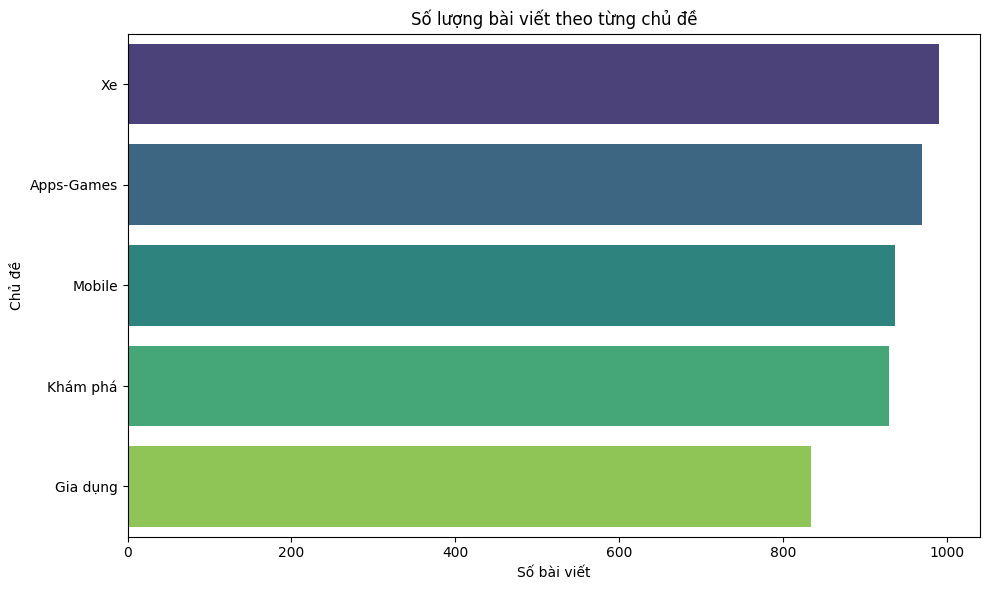

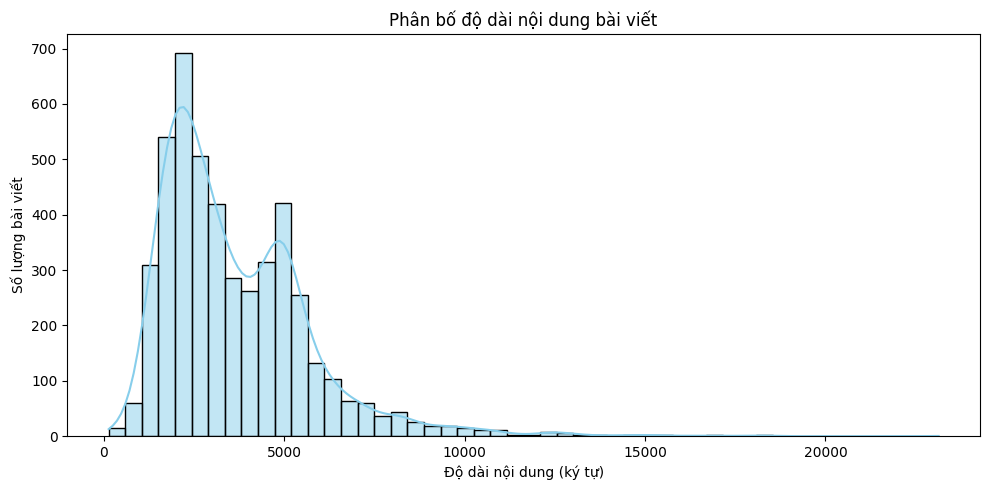

In [7]:
save_dir = '/content/drive/MyDrive/KKDL_Project'
final_file = os.path.join(save_dir, 'genk_data.csv')

df = None

if os.path.exists(final_file):
    try:
        df = pd.read_csv(final_file, encoding='utf-8')
        print(f"Đã đọc file dữ liệu: {final_file}")
        print(f"Tổng số bài viết trong file: {len(df)}")
        print(f"Các cột: {list(df.columns)}")
        print(f"Phân bố theo chủ đề:")
        print(df['category'].value_counts())

        if not df.empty:
            # Thống kê số lượng bài viết theo từng chủ đề
            print(f"\nPhân bố theo chủ đề:")
            category_stats = df['category'].value_counts()
            for category, count in category_stats.items():
                percentage = (count / len(df)) * 100
                print(f"   {category}: {count} bài viết ({percentage:.1f}%)")

            # Thống kê độ dài nội dung
            if 'content' in df.columns:
                print(f"\nThống kê độ dài nội dung:")
                df['content_length'] = df['content'].astype(str).apply(len)
                print(f"   Độ dài nội dung trung bình: {df['content_length'].mean():.0f} ký tự")
                print(f"   Độ dài nội dung ngắn nhất: {df['content_length'].min():.0f} ký tự")
                print(f"   Độ dài nội dung dài nhất: {df['content_length'].max():.0f} ký tự")

            #Số bài viết theo từng chủ đề
            plt.figure(figsize=(10, 6))
            sns.countplot(data=df, y='category', order=df['category'].value_counts().index, palette='viridis')
            plt.title('Số lượng bài viết theo từng chủ đề')
            plt.xlabel('Số bài viết')
            plt.ylabel('Chủ đề')
            plt.tight_layout()
            plt.show()

            #Phân bố độ dài nội dung (nếu cột content tồn tại)
            if 'content_length' in df.columns:
                plt.figure(figsize=(10, 5))
                sns.histplot(df['content_length'], bins=50, kde=True, color='skyblue')
                plt.title('Phân bố độ dài nội dung bài viết')
                plt.xlabel('Độ dài nội dung (ký tự)')
                plt.ylabel('Số lượng bài viết')
                plt.tight_layout()
                plt.show()

        else:
            print("DataFrame rỗng, không thể trực quan hóa.")

    except Exception as e:
        print(f"Đã xảy ra lỗi khi đọc file hoặc tạo biểu đồ: {e}")

else:
    print("File chưa được tạo!")

In [8]:
import re
import nltk
from underthesea import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("NLTK 'punkt' tokenizer not found. Downloading...")
    nltk.download('punkt')
except Exception as e:
    print(f"An unexpected error occurred while checking for NLTK 'punkt': {e}")


df = pd.read_csv('/content/drive/MyDrive/KKDL_Project/genk_data.csv', encoding='utf-8')
print(f"Tổng số bài viết ban đầu: {len(df)}")
print(f"Các cột ban đầu: {list(df.columns)}")

vietnamese_stopwords = [
    'và', 'của', 'là', 'cho', 'có', 'không', 'được', 'để', 'với', 'trong', 'trên', 'dưới', 'để', 'của', 'với', 'từ',
    'có', 'là', 'được', 'sẽ', 'đã', 'đang', 'các', 'một', 'hai', 'ba', 'này', 'đó',
    'khi', 'nếu', 'vì', 'do', 'theo', 'như', 'về', 'đến', 'cho', 'bởi', 'tại', 'sau',
    'trước', 'giữa', 'cùng', 'mà', 'rằng', 'ở', 'ra', 'vào', 'lại', 'đi', 'lên', 'xuống',
    'thì', 'mới', 'đều', 'cả', 'tất', 'toàn', 'nào', 'ai', 'gì', 'đâu', 'sao', 'bao',
    'bằng', 'rất', 'quá', 'khá', 'hơn', 'nữa', 'thêm', 'chỉ', 'chính', 'cũng', 'còn',
    'lại', 'phải', 'nên', 'cần', 'muốn', 'không', 'chẳng', 'chưa', 'đừng', 'hãy',
    'bài', 'viết', 'genk', 'đầy', 'đủ', 'thể', 'rất'

]

def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()

    # Loại bỏ các ký tự đặc biệt, số và punctuation
    text = re.sub(r'[^a-zàáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễìíịỉĩòóọỏõôồốộổỗơờớợởỡùúụủũưừứựửữỳýỵỷỹđ\s]', ' ', text)

    # Phân đoạn từ tiếng Việt
    try:
        tokens = word_tokenize(text, format="text")
    except Exception as e:
        print(f"Error tokenizing text: {text[:100]}, Error: {e}")
        tokens = ""

    # Loại bỏ stop words
    filtered_tokens = [word for word in tokens.split() if word not in vietnamese_stopwords]

    return " ".join(filtered_tokens)

df['full_content'] = df['title'] + " " + df['content']

print("Bắt đầu tiền xử lý văn bản")

df['processed_content'] = df['full_content'].apply(preprocess_text)
print("Tiền xử lý văn bản hoàn tất.")
print("5 dòng dữ liệu sau khi xử lý:")
# Display relevant columns including the new processed_content
print(df[['category', 'title', 'content', 'processed_content']].head())

# Trích xuất đặc trưng bằng TF-IDF
print("\nBắt đầu trích xuất đặc trưng bằng TF-IDF")
# Chỉ giữ lại 4000 từ có tần suất xuất hiện cao nhất
tfidf_vectorizer = TfidfVectorizer(max_features=4000, max_df=0.85, min_df=5)
X = tfidf_vectorizer.fit_transform(df['processed_content']).toarray()
print(f"Dữ liệu văn bản đã được chuyển thành ma trận số có kích thước: {X.shape}")

print("\nMã hóa nhãn")
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['category'])

print("Các lớp (category) và nhãn số tương ứng:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"- {class_name}: {i}")
print("\nQuá trình tiền xử lý dữ liệu hoàn tất")

# Save the DataFrame with the processed_content column
save_dir = '/content/drive/MyDrive/KKDL_Project'
preprocessed_filename = os.path.join(save_dir, 'genk_data_preprocessing.csv')

try:
    # Select columns to save
    # Ensure the columns exist before selecting
    cols_to_save = ['title', 'content', 'category', 'processed_content']
    # Filter cols_to_save to only include columns actually in df
    cols_to_save_existing = [col for col in cols_to_save if col in df.columns]

    if cols_to_save_existing:
        df_to_save = df[cols_to_save_existing]
        df_to_save.to_csv(preprocessed_filename, index=False, encoding='utf-8')
        print(f"\nĐã lưu dữ liệu tiền xử lý vào: {preprocessed_filename}")
        print(f"Kích thước file: {os.path.getsize(preprocessed_filename):,} bytes")
    else:
        print("\nKhông có cột nào để lưu vào file tiền xử lý.")

except Exception as e:
    print(f"\nLỗi khi lưu file tiền xử lý: {e}")

KeyboardInterrupt: 

Đã đọc file dữ liệu: /content/drive/MyDrive/KKDL_Project/genk_data_preprocessing.csv
Tổng số bài viết trong file: 4661
Các cột: ['title', 'content', 'category', 'processed_content']

Phân bố theo chủ đề:
   Xe: 991 bài viết (21.3%)
   Apps-Games: 970 bài viết (20.8%)
   Mobile: 937 bài viết (20.1%)
   Khám phá: 929 bài viết (19.9%)
   Gia dụng: 834 bài viết (17.9%)

Thống kê độ dài nội dung:
   Độ dài nội dung trung bình: 3652 ký tự
   Độ dài nội dung ngắn nhất: 140 ký tự
   Độ dài nội dung dài nhất: 23131 ký tự


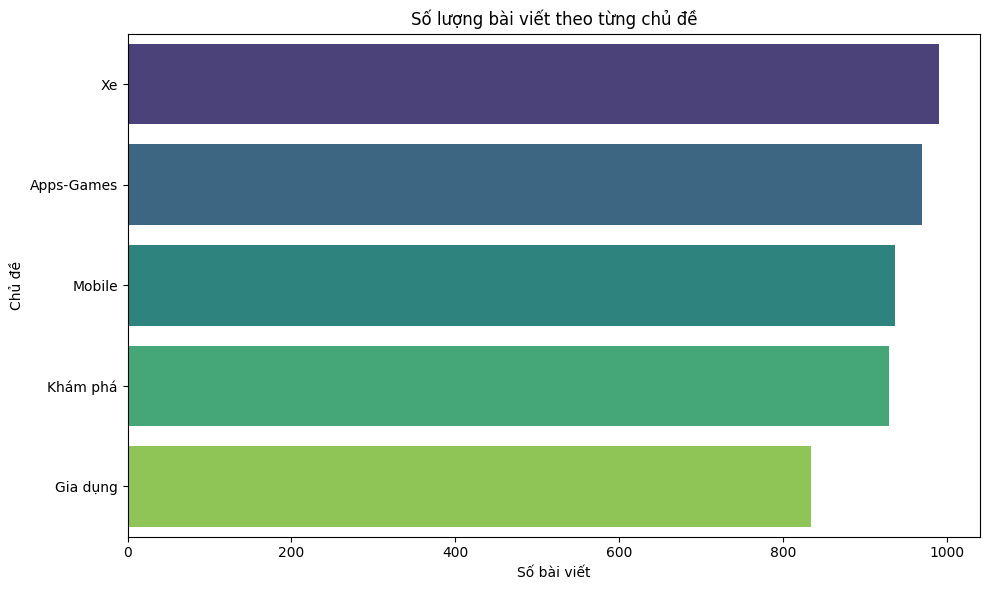

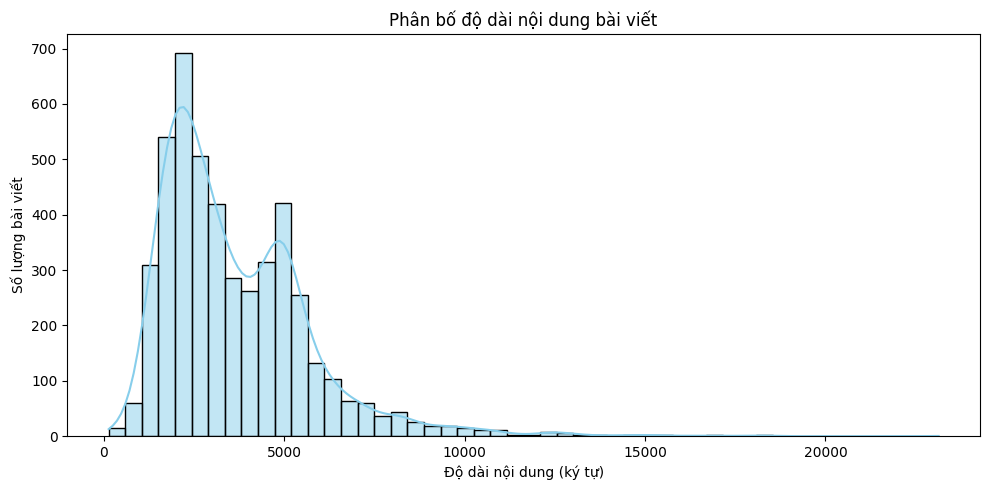

In [9]:
save_dir = '/content/drive/MyDrive/KKDL_Project'
final_file = os.path.join(save_dir, 'genk_data_preprocessing.csv')

df = None

if os.path.exists(final_file):
    try:
        df = pd.read_csv(final_file, encoding='utf-8')
        print(f"Đã đọc file dữ liệu: {final_file}")
        print(f"Tổng số bài viết trong file: {len(df)}")
        print(f"Các cột: {list(df.columns)}")

        if not df.empty:
            # Thống kê số lượng bài viết theo từng chủ đề
            print(f"\nPhân bố theo chủ đề:")
            category_stats = df['category'].value_counts()
            for category, count in category_stats.items():
                percentage = (count / len(df)) * 100
                print(f"   {category}: {count} bài viết ({percentage:.1f}%)")

            # Thống kê độ dài nội dung
            if 'content' in df.columns:
                print(f"\nThống kê độ dài nội dung:")
                df['content_length'] = df['content'].astype(str).apply(len)
                print(f"   Độ dài nội dung trung bình: {df['content_length'].mean():.0f} ký tự")
                print(f"   Độ dài nội dung ngắn nhất: {df['content_length'].min():.0f} ký tự")
                print(f"   Độ dài nội dung dài nhất: {df['content_length'].max():.0f} ký tự")

            #Số bài viết theo từng chủ đề
            plt.figure(figsize=(10, 6))
            sns.countplot(data=df, y='category', order=df['category'].value_counts().index, palette='viridis')
            plt.title('Số lượng bài viết theo từng chủ đề')
            plt.xlabel('Số bài viết')
            plt.ylabel('Chủ đề')
            plt.tight_layout()
            plt.show()

            #Phân bố độ dài nội dung
            if 'content_length' in df.columns:
                plt.figure(figsize=(10, 5))
                sns.histplot(df['content_length'], bins=50, kde=True, color='skyblue')
                plt.title('Phân bố độ dài nội dung bài viết')
                plt.xlabel('Độ dài nội dung (ký tự)')
                plt.ylabel('Số lượng bài viết')
                plt.tight_layout()
                plt.show()

    except Exception as e:
        print(f"Đã xảy ra lỗi khi đọc file hoặc tạo biểu đồ: {e}")
        df = None

else:
    print("File chưa được tạo!")

if df is not None and not df.empty:
    try:
        if 'label_encoder' in locals():
            classes = label_encoder.classes_
            encoded_labels = label_encoder.transform(classes)

            label_mapping_df = pd.DataFrame({
                'Category': classes,
                'Label Encoded': encoded_labels
            })

            display(label_mapping_df)

            category_counts = df['category'].value_counts()
            ordered_categories = category_counts.index
            ordered_encoded_labels = label_encoder.transform(ordered_categories)

            pie_labels = [f"{cat} ({label})" for cat, label in zip(ordered_categories, ordered_encoded_labels)]

            plt.figure(figsize=(8, 8))
            plt.pie(category_counts, labels=pie_labels, autopct='%1.1f%%', startangle=140)
            plt.title('Phân bố số lượng bài viết theo chủ đề')
            plt.axis('equal')
            plt.show()
    except Exception as e:
        print(f"Đã xảy ra lỗi khi tạo biểu đồ tròn hoặc bảng ánh xạ nhãn: {e}")

In [1]:
import torch
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from transformers import RobertaTokenizer, TFRobertaModel, AutoTokenizer
from tensorflow.keras.models import Model, Sequential #type: ignore
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Embedding, Bidirectional, GlobalMaxPooling1D, BatchNormalization #type: ignore
from tensorflow.keras.optimizers import Adam #type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint #type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer #type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences #type: ignore
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier
import re
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import unicodedata
import gc
import time
from tqdm import tqdm
import joblib
import warnings
warnings.filterwarnings('ignore')

In [10]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    DEVICE = "TPU"
    print(f"Đã kết nối với TPU")
except ValueError:
    if torch.cuda.is_available():
        DEVICE = "GPU"
        print(f"Đang sử dụng GPU: {torch.cuda.get_device_name(0)}")
    else:
        DEVICE = "CPU"
        print("Không tìm thấy GPU, đang sử dụng CPU.")

plt.style.use('seaborn-v0_8-whitegrid')
print("Môi trường sẵn sàng")

Không tìm thấy GPU, đang sử dụng CPU.
Môi trường sẵn sàng


In [11]:
save_dir = '/content/drive/MyDrive/KKDL_Project'
preprocessed_file = os.path.join(save_dir, 'genk_data_preprocessing.csv')
sample_file = os.path.join(save_dir, 'genk_data_sample.csv')
remaining_file = os.path.join(save_dir, 'genk_data_remaining.csv')

df = None

if os.path.exists(preprocessed_file):
    try:
        df = pd.read_csv(preprocessed_file, encoding='utf-8')
        print(f"Đã đọc file dữ liệu tiền xử lý: {preprocessed_file}")
        print(f"Tổng số bài viết ban đầu: {len(df)}")
        print(f"Các cột: {list(df.columns)}")
    except Exception as e:
        print(f"Đã xảy ra lỗi khi đọc file: {e}")
        df = None
else:
    print(f"Lỗi: Không tìm thấy file {preprocessed_file}")


if df is not None and not df.empty:
    try:
        df_remaining, df_sample = train_test_split(
            df,
            test_size=0.05,
            random_state=42,
            stratify=df['category']
        )

        print(f"\nĐã chia dữ liệu:")
        print(f"Kích thước tập mẫu (sample 5%): {len(df_sample)} bài viết")
        print(f"Kích thước tập còn lại (remaining 95%): {len(df_remaining)} bài viết")


        print("\nPhân bố theo chủ đề trong tập mẫu 5%:")
        print(df_sample['category'].value_counts())

        df_sample.to_csv(sample_file, index=False, encoding='utf-8')
        print(f"\nĐã lưu tập mẫu 5% vào file: {sample_file}")
        print(f"Kích thước file: {os.path.getsize(sample_file):,} bytes")

        df_remaining.to_csv(remaining_file, index=False, encoding='utf-8')
        print(f"Đã lưu tập còn lại 95% vào file: {remaining_file}")
        print(f"Kích thước file: {os.path.getsize(remaining_file):,} bytes")


    except Exception as e:
        print(f"Đã xảy ra lỗi trong quá trình lấy mẫu hoặc lưu file: {e}")

else:
    print("Không có dữ liệu để xử lý.")

Đã đọc file dữ liệu tiền xử lý: /content/drive/MyDrive/KKDL_Project/genk_data_preprocessing.csv
Tổng số bài viết ban đầu: 4661
Các cột: ['title', 'content', 'category', 'processed_content']

Đã chia dữ liệu:
Kích thước tập mẫu (sample 5%): 234 bài viết
Kích thước tập còn lại (remaining 95%): 4427 bài viết

Phân bố theo chủ đề trong tập mẫu 5%:
category
Xe            50
Apps-Games    49
Mobile        47
Khám phá      46
Gia dụng      42
Name: count, dtype: int64

Đã lưu tập mẫu 5% vào file: /content/drive/MyDrive/KKDL_Project/genk_data_sample.csv
Kích thước file: 1,959,244 bytes
Đã lưu tập còn lại 95% vào file: /content/drive/MyDrive/KKDL_Project/genk_data_remaining.csv
Kích thước file: 38,477,826 bytes


Đã tải thành công dữ liệu từ: /content/drive/MyDrive/KKDL_Project/genk_data_remaining.csv

Dữ liệu được chia thành:
Tập huấn luyện: 3541 mẫu
Tập kiểm thử: 886 mẫu


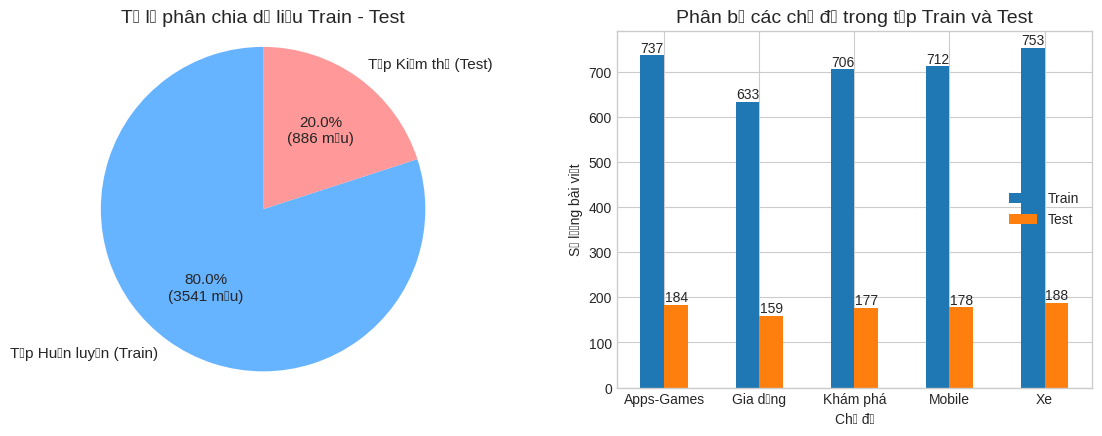

Kích thước ma trận TF-IDF: (3541, 4000)


In [12]:
save_dir = '/content/drive/MyDrive/KKDL_Project'
preprocessed_file = os.path.join(save_dir, 'genk_data_remaining.csv')

try:
    df = pd.read_csv(preprocessed_file)
    print(f"Đã tải thành công dữ liệu từ: {preprocessed_file}")
    df['processed_content'].fillna('', inplace=True)
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file {preprocessed_file}")
    df = None

if df is not None:
    X = df['processed_content']
    y = df['category']

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    plt.figure(figsize=(12, 5))
    ax1 = plt.subplot(1, 2, 1)

    train_size = len(X_train)
    test_size = len(X_test)
    sizes = [train_size, test_size]
    labels = ['Tập Huấn luyện (Train)', 'Tập Kiểm thử (Test)']

    def func(pct, allvals):
        absolute = int(round(pct/100.*np.sum(allvals)))
        return f"{pct:.1f}%\n({absolute:d} mẫu)"

    ax1.pie(sizes,
            labels=labels,
            autopct=lambda pct: func(pct, sizes),
            colors=['#66b3ff','#ff9999'],
            startangle=90,
            textprops={'fontsize': 11})

    plt.title('Tỉ lệ phân chia dữ liệu Train - Test', fontsize=14)
    plt.axis('equal')

    ax2 = plt.subplot(1, 2, 2)
    train_counts = pd.Series(y_train).value_counts().sort_index()
    test_counts = pd.Series(y_test).value_counts().sort_index()

    plot_df = pd.DataFrame({
        'Train': train_counts.values,
        'Test': test_counts.values
    }, index=label_encoder.classes_)

    plot_df.plot(kind='bar', rot=0, ax=ax2)
    plt.title('Phân bố các chủ đề trong tập Train và Test', fontsize=14)
    plt.ylabel('Số lượng bài viết')
    plt.xlabel('Chủ đề')

    for container in ax2.containers:
        ax2.bar_label(container)

    plt.tight_layout(pad=3.0)

    print(f"\nDữ liệu được chia thành:")
    print(f"Tập huấn luyện: {train_size} mẫu")
    print(f"Tập kiểm thử: {test_size} mẫu")
    plt.show()

tfidf_vectorizer = TfidfVectorizer(max_features=4000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Kích thước ma trận TF-IDF: {X_train_tfidf.shape}")

In [13]:
# KNN
print("Đang huấn luyện KNN")
knn_params = {'n_neighbors': [3, 5, 7]}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy', n_jobs=-1)
knn_grid.fit(X_train_tfidf, y_train)
knn_best_model = knn_grid.best_estimator_
knn_predictions = knn_best_model.predict(X_test_tfidf)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print(f"Accuracy KNN: {knn_accuracy:.4f}\n")

# Naive Bayes
print("Đang huấn luyện Naive Bayes")
nb_params = {'alpha': [0.1, 0.5, 1.0]}
nb_grid = GridSearchCV(MultinomialNB(), nb_params, cv=5, scoring='accuracy', n_jobs=-1)
nb_grid.fit(X_train_tfidf, y_train)
nb_best_model = nb_grid.best_estimator_
nb_predictions = nb_best_model.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print(f"Accuracy Naive Bayes: {nb_accuracy:.4f}\n")

# SVM
print("Đang huấn luyện SVM")
svm_params = {'C': [0.1, 1, 10]}
svm_grid = GridSearchCV(SVC(kernel='linear'), svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train_tfidf, y_train)
svm_best_model = svm_grid.best_estimator_
svm_predictions = svm_best_model.predict(X_test_tfidf)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f"Accuracy SVM: {svm_accuracy:.4f}\n")

# Logistic Regression
print("Đang huấn luyện Logistic Regression")
lr_params = {'C': [0.01, 0.1, 1.0, 10.0]}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), lr_params, cv=5, scoring='accuracy', n_jobs=-1)
lr_grid.fit(X_train_tfidf, y_train)
lr_best_model = lr_grid.best_estimator_
lr_predictions = lr_best_model.predict(X_test_tfidf)
lr_accuracy = accuracy_score(y_test, lr_predictions)
print(f"Accuracy Logistic Regression: {lr_accuracy:.4f}\n")

# Random Forest
print("Đang huấn luyện Random Forest")
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train_tfidf, y_train)
rf_best_model = rf_grid.best_estimator_
rf_predictions = rf_best_model.predict(X_test_tfidf)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Accuracy Random Forest: {rf_accuracy:.4f}\n")

Đang huấn luyện KNN
Accuracy KNN: 0.9142

Đang huấn luyện Naive Bayes
Accuracy Naive Bayes: 0.9176

Đang huấn luyện SVM
Accuracy SVM: 0.9458

Đang huấn luyện Logistic Regression
Accuracy Logistic Regression: 0.9470

Đang huấn luyện Random Forest
Accuracy Random Forest: 0.9278



In [14]:
# RNN
print("Đang huấn luyện RNN")

save_dir = '/content/drive/MyDrive/KKDL_Project'
preprocessed_file = os.path.join(save_dir, 'genk_data_remaining.csv')
df_rnn = pd.read_csv(preprocessed_file)
df_rnn['processed_content'].fillna('', inplace=True)

X_rnn = df_rnn['processed_content']
y_rnn = df_rnn['category']

label_encoder_rnn = LabelEncoder()
y_rnn_encoded = label_encoder_rnn.fit_transform(y_rnn)

X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(
    X_rnn, y_rnn_encoded, test_size=0.2, random_state=42, stratify=y_rnn_encoded
)

MAX_WORDS = 10000
MAX_LEN_RNN = 256

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_rnn)

X_train_rnn_seq = tokenizer.texts_to_sequences(X_train_rnn)
X_test_rnn_seq = tokenizer.texts_to_sequences(X_test_rnn)

X_train_rnn_padded = pad_sequences(X_train_rnn_seq, maxlen=MAX_LEN_RNN, padding='post', truncating='post')
X_test_rnn_padded = pad_sequences(X_test_rnn_seq, maxlen=MAX_LEN_RNN, padding='post', truncating='post')

embedding_dim = 100
lstm_units = 64
num_classes = len(label_encoder_rnn.classes_)

rnn_model = Sequential([
    Embedding(MAX_WORDS, embedding_dim, input_length=MAX_LEN_RNN),
    Bidirectional(LSTM(lstm_units, return_sequences=True)), # Changed SimpleRNN to LSTM
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs_rnn = 10
batch_size_rnn = 32

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

history_rnn = rnn_model.fit(
    X_train_rnn_padded,
    y_train_rnn,
    epochs=epochs_rnn,
    batch_size=batch_size_rnn,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

loss_rnn, accuracy_rnn = rnn_model.evaluate(X_test_rnn_padded, y_test_rnn, verbose=0)
rnn_predictions = rnn_model.predict(X_test_rnn_padded)
rnn_predictions_classes = np.argmax(rnn_predictions, axis=1)
print(rnn_model.summary())
print(f"Accuracy RNN: {accuracy_rnn:.4f}\n")

model_accuracies = {
    'Naive Bayes': nb_accuracy,
    'SVM': svm_accuracy,
    'Random Forest': rf_accuracy,
    'Logistic Regression': lr_accuracy,
    'KNN': knn_accuracy,
    'RNN': accuracy_rnn
}

Đang huấn luyện RNN
Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 44s 410ms/step - accuracy: 0.3351 - loss: 1.5277 - val_accuracy: 0.6827 - val_loss: 1.0936 - learning_rate: 0.0010
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 37s 410ms/step - accuracy: 0.5590 - loss: 1.0897 - val_accuracy: 0.7518 - val_loss: 0.7054 - learning_rate: 0.0010
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 41s 413ms/step - accuracy: 0.8230 - loss: 0.6005 - val_accuracy: 0.8717 - val_loss: 0.3801 - learning_rate: 0.0010
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 39s 395ms/step - accuracy: 0.8870 - loss: 0.3731 - val_accuracy: 0.8434 - val_loss: 0.5009 - learning_rate: 0.0010
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 38s 425ms/step - accuracy: 0.9021 - loss: 0.3230 - val_accuracy: 0.8900 - val_loss: 0.3633 - learning_rate: 0.0010
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 46s 482ms/step - accuracy: 0.9389 - loss: 0.2315 - val_accuracy: 0.9055 - val_loss: 0.3029 - learning_rate: 0.0010
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 400ms/step - accurac

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 256, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256, 128)       │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,279,185 (12.51 MB)

 Trainable params: 1,093,061 (4.17 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,186,124 (8.34 MB)

None
Accuracy RNN: 0.9097



BẮT ĐẦU ĐÁNH GIÁ, SO SÁNH VÀ LƯU CÁC MÔ HÌNH

ĐÁNH GIÁ MÔ HÌNH: Naive Bayes
Báo cáo phân loại cho Naive Bayes:

              precision    recall  f1-score   support

  Apps-Games       0.88      0.96      0.92       184
    Gia dụng       0.93      0.93      0.93       159
    Khám phá       0.94      0.82      0.87       177
      Mobile       0.92      0.91      0.91       178
          Xe       0.93      0.97      0.95       188

    accuracy                           0.92       886
   macro avg       0.92      0.92      0.92       886
weighted avg       0.92      0.92      0.92       886

Đã lưu biểu đồ vào: /content/drive/MyDrive/KKDL_Project/confusion_matrix_naive_bayes.png


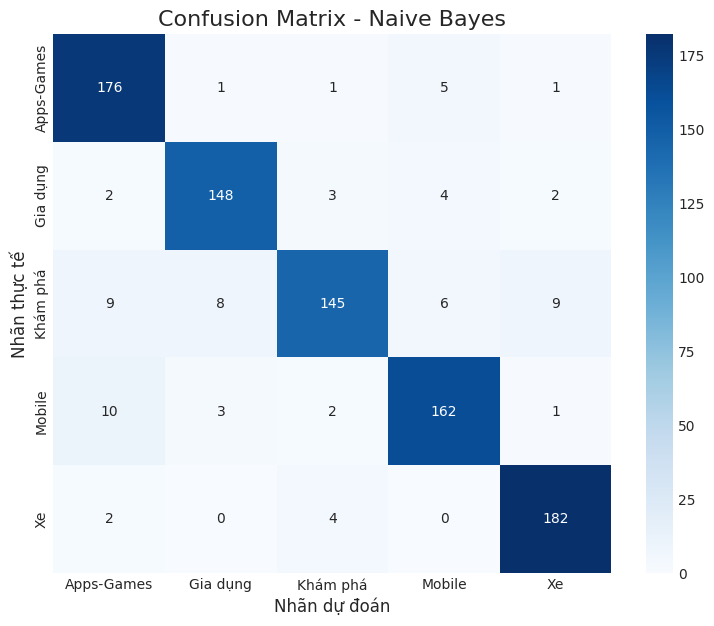

Đang lưu mô hình Naive Bayes...
Đã lưu mô hình Scikit-learn vào: /content/drive/MyDrive/KKDL_Project/model_naive_bayes.joblib

ĐÁNH GIÁ MÔ HÌNH: SVM
Báo cáo phân loại cho SVM:

              precision    recall  f1-score   support

  Apps-Games       0.93      0.96      0.94       184
    Gia dụng       0.93      0.96      0.94       159
    Khám phá       0.96      0.90      0.93       177
      Mobile       0.96      0.93      0.95       178
          Xe       0.95      0.98      0.97       188

    accuracy                           0.95       886
   macro avg       0.95      0.95      0.95       886
weighted avg       0.95      0.95      0.95       886

Đã lưu biểu đồ vào: /content/drive/MyDrive/KKDL_Project/confusion_matrix_svm.png


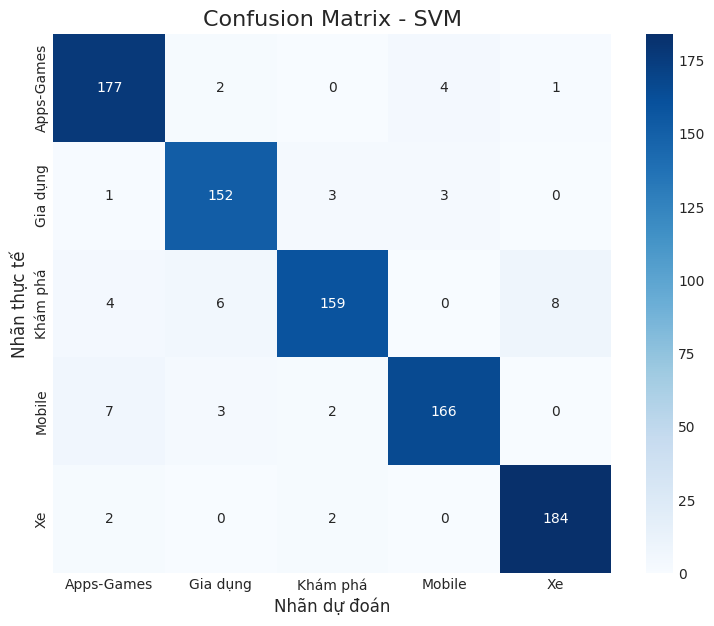

Đang lưu mô hình SVM...
Đã lưu mô hình Scikit-learn vào: /content/drive/MyDrive/KKDL_Project/model_svm.joblib

ĐÁNH GIÁ MÔ HÌNH: Random Forest
Báo cáo phân loại cho Random Forest:

              precision    recall  f1-score   support

  Apps-Games       0.88      0.96      0.92       184
    Gia dụng       0.96      0.94      0.95       159
    Khám phá       0.95      0.85      0.90       177
      Mobile       0.92      0.91      0.92       178
          Xe       0.94      0.98      0.96       188

    accuracy                           0.93       886
   macro avg       0.93      0.93      0.93       886
weighted avg       0.93      0.93      0.93       886

Đã lưu biểu đồ vào: /content/drive/MyDrive/KKDL_Project/confusion_matrix_random_forest.png


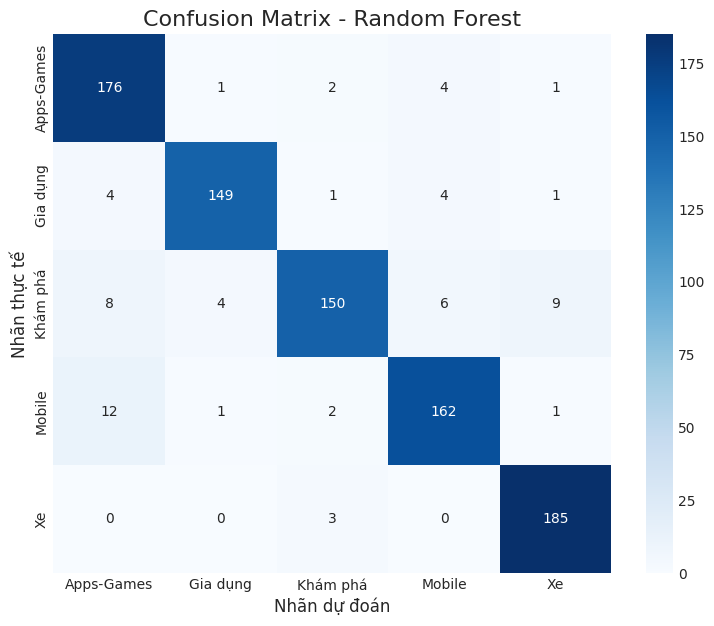

Đang lưu mô hình Random Forest...
Đã lưu mô hình Scikit-learn vào: /content/drive/MyDrive/KKDL_Project/model_random_forest.joblib

ĐÁNH GIÁ MÔ HÌNH: Logistic Regression
Báo cáo phân loại cho Logistic Regression:

              precision    recall  f1-score   support

  Apps-Games       0.93      0.96      0.94       184
    Gia dụng       0.93      0.96      0.94       159
    Khám phá       0.96      0.90      0.93       177
      Mobile       0.96      0.93      0.95       178
          Xe       0.96      0.98      0.97       188

    accuracy                           0.95       886
   macro avg       0.95      0.95      0.95       886
weighted avg       0.95      0.95      0.95       886

Đã lưu biểu đồ vào: /content/drive/MyDrive/KKDL_Project/confusion_matrix_logistic_regression.png


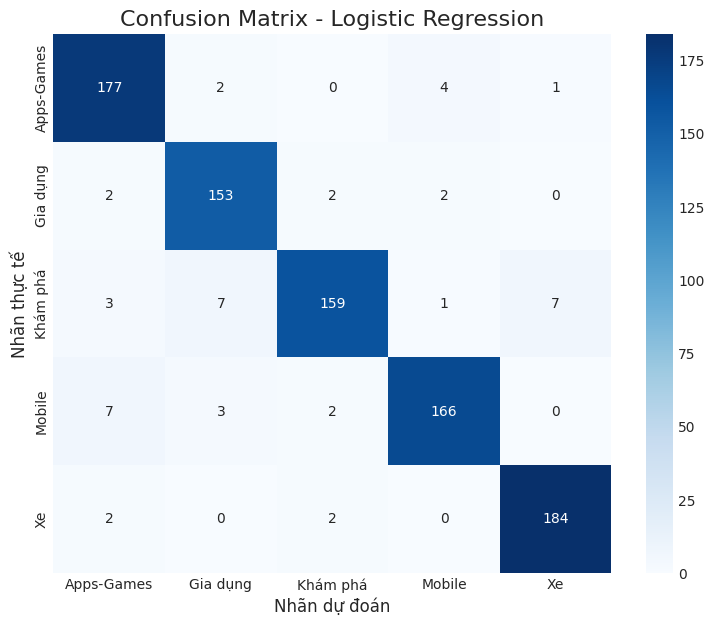

Đang lưu mô hình Logistic Regression...
Đã lưu mô hình Scikit-learn vào: /content/drive/MyDrive/KKDL_Project/model_logistic_regression.joblib

ĐÁNH GIÁ MÔ HÌNH: KNN
Báo cáo phân loại cho KNN:

              precision    recall  f1-score   support

  Apps-Games       0.89      0.92      0.90       184
    Gia dụng       0.89      0.93      0.91       159
    Khám phá       0.96      0.81      0.88       177
      Mobile       0.93      0.93      0.93       178
          Xe       0.91      0.98      0.94       188

    accuracy                           0.91       886
   macro avg       0.92      0.91      0.91       886
weighted avg       0.92      0.91      0.91       886

Đã lưu biểu đồ vào: /content/drive/MyDrive/KKDL_Project/confusion_matrix_knn.png


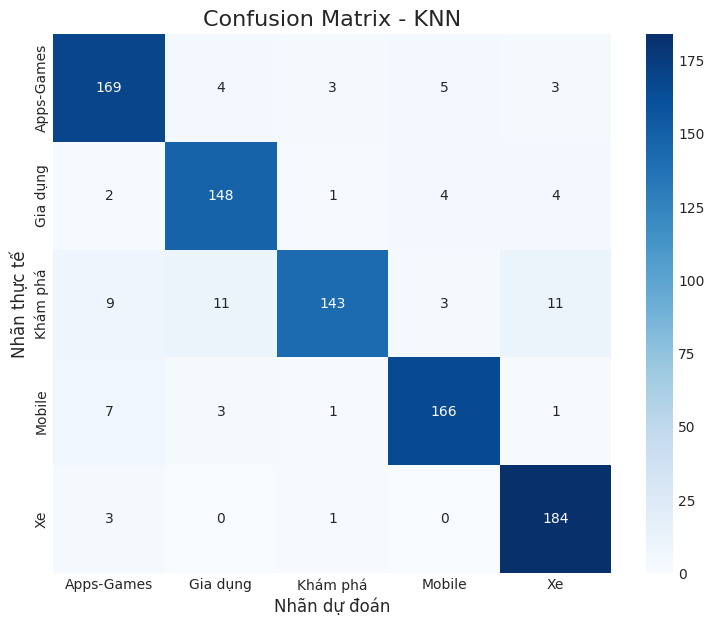

Đang lưu mô hình KNN...
Đã lưu mô hình Scikit-learn vào: /content/drive/MyDrive/KKDL_Project/model_knn.joblib

ĐÁNH GIÁ MÔ HÌNH: RNN
Báo cáo phân loại cho RNN:

              precision    recall  f1-score   support

  Apps-Games       0.90      0.90      0.90       184
    Gia dụng       0.91      0.91      0.91       159
    Khám phá       0.90      0.86      0.88       177
      Mobile       0.94      0.90      0.92       178
          Xe       0.91      0.96      0.93       188

    accuracy                           0.91       886
   macro avg       0.91      0.91      0.91       886
weighted avg       0.91      0.91      0.91       886

Đã lưu biểu đồ vào: /content/drive/MyDrive/KKDL_Project/confusion_matrix_rnn.png


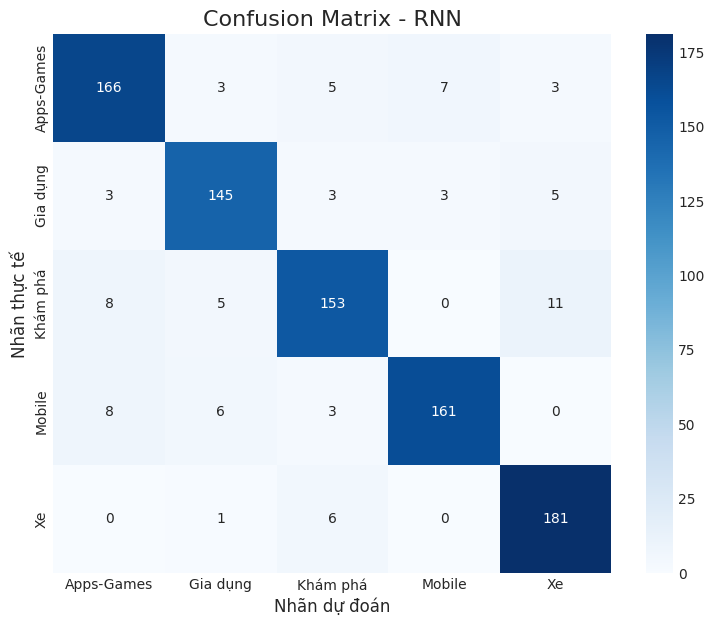

Đang lưu mô hình RNN...
Đã lưu mô hình Keras vào: /content/drive/MyDrive/KKDL_Project/model_rnn.keras

LƯU CÁC ĐỐI TƯỢNG TIỀN XỬ LÝ

Đã lưu TF-IDF Vectorizer vào: /content/drive/MyDrive/KKDL_Project/tfidf_vectorizer.joblib
Đã lưu Label Encoder vào: /content/drive/MyDrive/KKDL_Project/label_encoder.joblib
Đã lưu RNN Tokenizer và cấu hình vào: /content/drive/MyDrive/KKDL_Project/rnn_tokenizer_config.joblib


Bảng so sánh các chỉ số của mô hình:


,Accuracy,Precision,Recall,F1-score
Logistic Regression,0.946953,0.947096,0.946767,0.946512
SVM,0.945824,0.945991,0.945509,0.945392
Random Forest,0.927765,0.930040,0.927048,0.927505
Naive Bayes,0.917607,0.918699,0.916949,0.916704
KNN,0.914221,0.915952,0.913703,0.913115
RNN,0.909707,0.910014,0.909158,0.909258


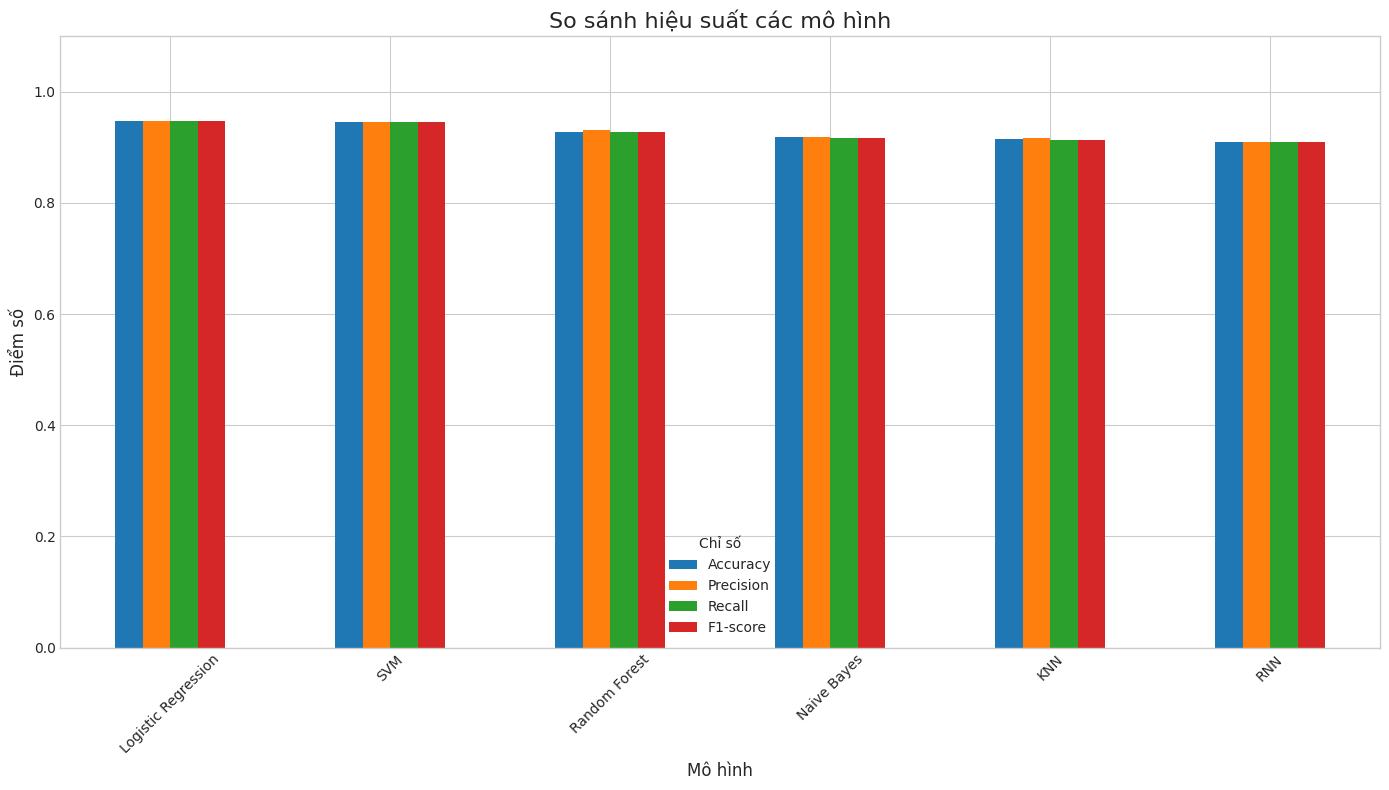


Mô hình tốt nhất dựa trên F1-score: 'Logistic Regression', với F1-score = 0.9465


In [18]:
import joblib

models = {}
predictions = {}
model_results = {}

if 'nb_best_model' in locals():
    models['Naive Bayes'] = nb_best_model
    predictions['Naive Bayes'] = nb_predictions

if 'svm_best_model' in locals():
    models['SVM'] = svm_best_model
    predictions['SVM'] = svm_predictions

if 'rf_best_model' in locals():
    models['Random Forest'] = rf_best_model
    predictions['Random Forest'] = rf_predictions

if 'lr_best_model' in locals():
    models['Logistic Regression'] = lr_best_model
    predictions['Logistic Regression'] = lr_predictions

if 'knn_best_model' in locals():
    models['KNN'] = knn_best_model
    predictions['KNN'] = knn_predictions

if 'rnn_model' in locals() and 'rnn_predictions_classes' in locals():
    models['RNN'] = rnn_model
    predictions['RNN'] = rnn_predictions_classes

print("BẮT ĐẦU ĐÁNH GIÁ, SO SÁNH VÀ LƯU CÁC MÔ HÌNH")

save_dir = '/content/drive/MyDrive/KKDL_Project'
os.makedirs(save_dir, exist_ok=True)

for model_name, model_instance in models.items():
    print(f"\n{'='*20}\nĐÁNH GIÁ MÔ HÌNH: {model_name}\n{'='*20}")
    if model_name in predictions:
        current_predictions = predictions[model_name]

        print(f"Báo cáo phân loại cho {model_name}:\n")

        report = classification_report(y_test, current_predictions, target_names=label_encoder.classes_, output_dict=True)
        print(classification_report(y_test, current_predictions, target_names=label_encoder.classes_))

        accuracy = report['accuracy']
        macro_avg = report['macro avg']
        model_results[model_name] = {
            'Accuracy': accuracy,
            'Precision': macro_avg['precision'],
            'Recall': macro_avg['recall'],
            'F1-score': macro_avg['f1-score']
        }

        cm = confusion_matrix(y_test, current_predictions)
        plt.figure(figsize=(9, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
        plt.title(f'Confusion Matrix - {model_name}', fontsize=16)
        plt.ylabel('Nhãn thực tế', fontsize=12)
        plt.xlabel('Nhãn dự đoán', fontsize=12)

        plot_save_path = os.path.join(save_dir, f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png')
        plt.savefig(plot_save_path)
        print(f"Đã lưu biểu đồ vào: {plot_save_path}")
        plt.show()

        print(f"Đang lưu mô hình {model_name}...")
        try:
            if model_name == 'RNN':
                model_save_path = os.path.join(save_dir, f'model_{model_name.lower()}.keras')
                model_instance.save(model_save_path)
                print(f"Đã lưu mô hình Keras vào: {model_save_path}")
            else:
                model_save_path = os.path.join(save_dir, f'model_{model_name.lower().replace(" ", "_")}.joblib')
                joblib.dump(model_instance, model_save_path)
                print(f"Đã lưu mô hình Scikit-learn vào: {model_save_path}")
        except Exception as e:
            print(f"Lỗi khi lưu mô hình {model_name}: {e}")
    else:
        print(f"Không tìm thấy dự đoán cho mô hình {model_name}.")

print(f"\nLƯU CÁC ĐỐI TƯỢNG TIỀN XỬ LÝ\n")
try:
    vectorizer_save_path = os.path.join(save_dir, 'tfidf_vectorizer.joblib')
    joblib.dump(tfidf_vectorizer, vectorizer_save_path)
    print(f"Đã lưu TF-IDF Vectorizer vào: {vectorizer_save_path}")

    label_encoder_save_path = os.path.join(save_dir, 'label_encoder.joblib')
    joblib.dump(label_encoder, label_encoder_save_path)
    print(f"Đã lưu Label Encoder vào: {label_encoder_save_path}")

    if 'tokenizer' in locals():
        tokenizer_config = {'tokenizer': tokenizer, 'max_len': MAX_LEN_RNN}
        tokenizer_save_path = os.path.join(save_dir, 'rnn_tokenizer_config.joblib')
        joblib.dump(tokenizer_config, tokenizer_save_path)
        print(f"Đã lưu RNN Tokenizer và cấu hình vào: {tokenizer_save_path}")
except Exception as e:
    print(f"Lỗi khi lưu các đối tượng tiền xử lý: {e}")

if model_results:
    df_results = pd.DataFrame.from_dict(model_results, orient='index')
    df_results = df_results.sort_values(by='F1-score', ascending=False)

    print("\n\nBảng so sánh các chỉ số của mô hình:")
    display(df_results)

    df_results.plot(kind='bar', figsize=(14, 8), rot=45)
    plt.title('So sánh hiệu suất các mô hình', fontsize=16)
    plt.ylabel('Điểm số', fontsize=12)
    plt.xlabel('Mô hình', fontsize=12)
    plt.ylim(0, 1.1)
    plt.legend(title='Chỉ số')
    plt.tight_layout()
    plt.show()

    best_model_name = df_results.index[0]
    best_model_f1 = df_results.iloc[0]['F1-score']
    print(f"\nMô hình tốt nhất dựa trên F1-score: '{best_model_name}', với F1-score = {best_model_f1:.4f}")
else:
    print("\nKhông có kết quả để hiển thị.")

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import numpy as np

print("BẮT ĐẦU TRÍCH XUẤT ĐẶC TRƯNG BẰNG BAG-OF-WORDS")

# Khởi tạo CountVectorizer
bow_vectorizer = CountVectorizer(max_features=4000, max_df=0.85, min_df=5)

# Tạo ma trận đặc trưng Bag-of-Words
print("\nĐang tạo ma trận đặc trưng Bag-of-Words")
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

print(f"Đã tạo ma trận đặc trưng X_train_bow với kích thước: {X_train_bow.shape}")
print(f"Kích thước tập kiểm thử X_test_bow: {X_test_bow.shape}")

BẮT ĐẦU TRÍCH XUẤT ĐẶC TRƯNG BẰNG BAG-OF-WORDS

Đang tạo ma trận đặc trưng Bag-of-Words
Đã tạo ma trận đặc trưng X_train_bow với kích thước: (3541, 4000)
Kích thước tập kiểm thử X_test_bow: (886, 4000)


In [28]:
bow_models = {}
bow_predictions = {}

# KNN
print("Đang huấn luyện KNN (BoW)")
knn_params_bow = {'n_neighbors': [3, 5, 7]}
knn_grid_bow = GridSearchCV(KNeighborsClassifier(), knn_params_bow, cv=5, scoring='accuracy', n_jobs=1)
knn_grid_bow.fit(X_train_bow, y_train)
bow_models['KNN'] = knn_grid_bow.best_estimator_
bow_predictions['KNN'] = bow_models['KNN'].predict(X_test_bow)

# Multinomial Naive Bayes
print("\nĐang huấn luyện Naive Bayes (BoW)")
nb_params_bow = {'alpha': [0.1, 0.5, 1.0]}
nb_grid_bow = GridSearchCV(MultinomialNB(), nb_params_bow, cv=5, scoring='accuracy', n_jobs=1)
nb_grid_bow.fit(X_train_bow, y_train)
bow_models['Naive Bayes'] = nb_grid_bow.best_estimator_
bow_predictions['Naive Bayes'] = bow_models['Naive Bayes'].predict(X_test_bow)

# SVM
print("\nĐang huấn luyện SVM (BoW)")
svm_params_bow = {'C': [0.1, 1, 10]}
svm_grid_bow = GridSearchCV(SVC(kernel='linear', probability=True), svm_params_bow, cv=5, scoring='accuracy', n_jobs=1)
svm_grid_bow.fit(X_train_bow, y_train)
bow_models['SVM'] = svm_grid_bow.best_estimator_
bow_predictions['SVM'] = bow_models['SVM'].predict(X_test_bow)

# Random Forest
print("\nĐang huấn luyện Random Forest (BoW)")
rf_params_bow = {'n_estimators': [100, 200]}
rf_grid_bow = GridSearchCV(RandomForestClassifier(random_state=42), rf_params_bow, cv=5, n_jobs=1)
rf_grid_bow.fit(X_train_bow, y_train)
bow_models['Random Forest'] = rf_grid_bow.best_estimator_
bow_predictions['Random Forest'] = bow_models['Random Forest'].predict(X_test_bow)
print("-> Random Forest hoàn tất.")

# Logistic Regression
print("\nĐang huấn luyện Logistic Regression (BoW)")
lr_params_bow = {'C': [0.1, 1.0, 10]}
lr_grid_bow = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), lr_params_bow, cv=5, n_jobs=1)
lr_grid_bow.fit(X_train_bow, y_train)
bow_models['Logistic Regression'] = lr_grid_bow.best_estimator_
bow_predictions['Logistic Regression'] = bow_models['Logistic Regression'].predict(X_test_bow)

Đang huấn luyện KNN (BoW)

Đang huấn luyện Naive Bayes (BoW)

Đang huấn luyện SVM (BoW)

Đang huấn luyện Random Forest (BoW)
-> Random Forest hoàn tất.

Đang huấn luyện Logistic Regression (BoW)


In [29]:
print("\nĐang huấn luyện MLP")

X_train_bow_dense = X_train_bow.toarray()
X_test_bow_dense = X_test_bow.toarray()

input_dim = X_train_bow_dense.shape[1]
num_classes = len(label_encoder.classes_)

mlp_model = Sequential([
    Dense(128, input_dim=input_dim, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

mlp_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_mlp = mlp_model.fit(
    X_train_bow_dense,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0
)

bow_models['MLP'] = mlp_model
mlp_pred_probs = mlp_model.predict(X_test_bow_dense)
bow_predictions['MLP'] = np.argmax(mlp_pred_probs, axis=1)
print(mlp_model.summary())
print("\nĐÃ HUẤN LUYỆN XONG")


Đang huấn luyện MLP
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │       512,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,562,129 (5.96 MB)

 Trainable params: 520,709 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,041,420 (3.97 MB)

None

ĐÃ HUẤN LUYỆN XONG



ĐÁNH GIÁ MÔ HÌNH: KNN (BoW)

Báo cáo phân loại cho KNN:

              precision    recall  f1-score   support

  Apps-Games       0.74      0.86      0.80       184
    Gia dụng       0.77      0.91      0.83       159
    Khám phá       0.98      0.58      0.73       177
      Mobile       0.95      0.81      0.88       178
          Xe       0.80      0.96      0.87       188

    accuracy                           0.83       886
   macro avg       0.85      0.82      0.82       886
weighted avg       0.85      0.83      0.82       886

Đã lưu biểu đồ vào: /content/drive/MyDrive/KKDL_Project/bow_confusion_matrix_knn.png


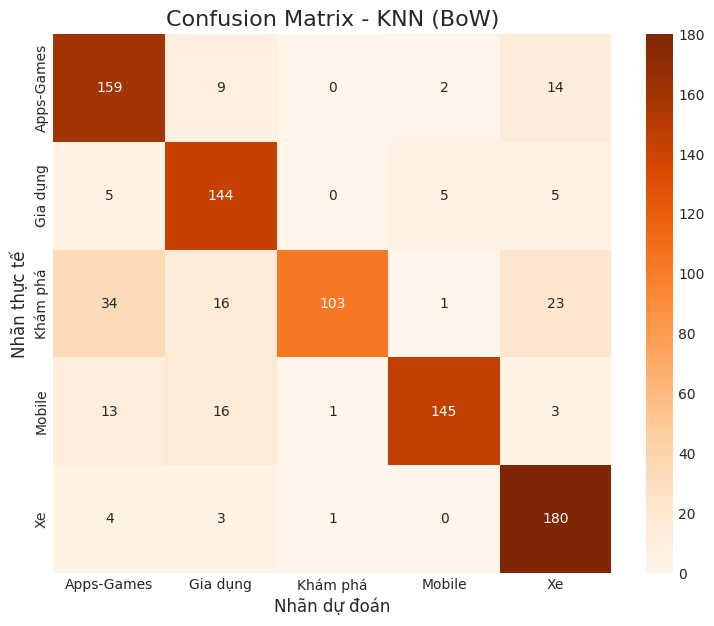

Đang lưu mô hình KNN
Đã lưu mô hình Scikit-learn vào: /content/drive/MyDrive/KKDL_Project/bow_model_knn.joblib

ĐÁNH GIÁ MÔ HÌNH: Naive Bayes (BoW)

Báo cáo phân loại cho Naive Bayes:

              precision    recall  f1-score   support

  Apps-Games       0.86      0.96      0.91       184
    Gia dụng       0.94      0.92      0.93       159
    Khám phá       0.94      0.82      0.88       177
      Mobile       0.91      0.90      0.90       178
          Xe       0.94      0.96      0.95       188

    accuracy                           0.91       886
   macro avg       0.92      0.91      0.91       886
weighted avg       0.92      0.91      0.91       886

Đã lưu biểu đồ vào: /content/drive/MyDrive/KKDL_Project/bow_confusion_matrix_naive_bayes.png


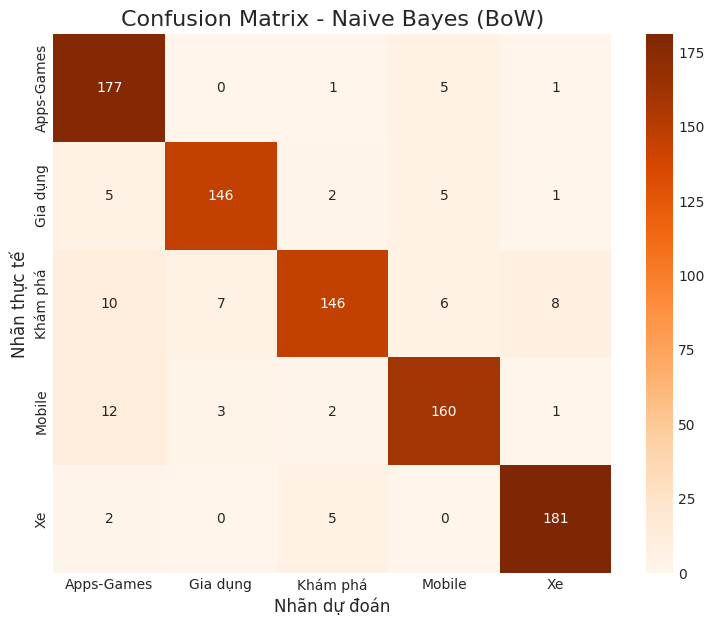

Đang lưu mô hình Naive Bayes
Đã lưu mô hình Scikit-learn vào: /content/drive/MyDrive/KKDL_Project/bow_model_naive_bayes.joblib

ĐÁNH GIÁ MÔ HÌNH: SVM (BoW)

Báo cáo phân loại cho SVM:

              precision    recall  f1-score   support

  Apps-Games       0.92      0.94      0.93       184
    Gia dụng       0.94      0.96      0.95       159
    Khám phá       0.92      0.87      0.89       177
      Mobile       0.94      0.92      0.93       178
          Xe       0.94      0.97      0.96       188

    accuracy                           0.93       886
   macro avg       0.93      0.93      0.93       886
weighted avg       0.93      0.93      0.93       886

Đã lưu biểu đồ vào: /content/drive/MyDrive/KKDL_Project/bow_confusion_matrix_svm.png


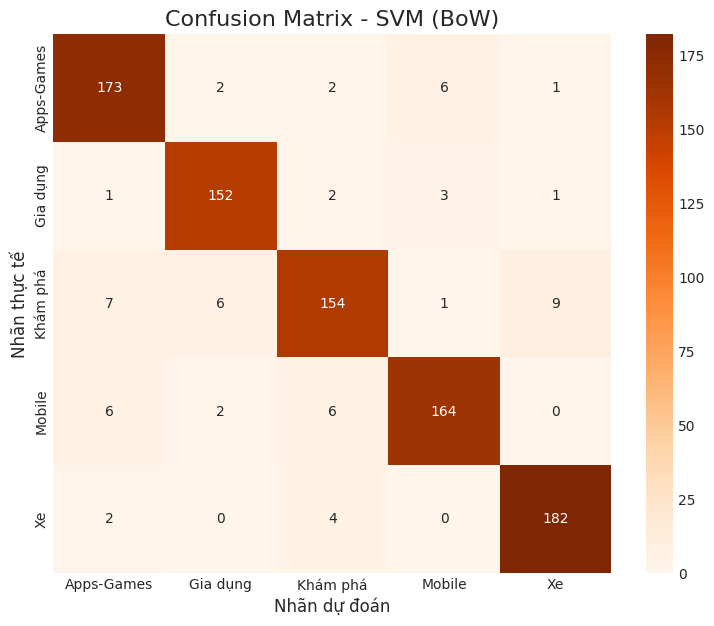

Đang lưu mô hình SVM
Đã lưu mô hình Scikit-learn vào: /content/drive/MyDrive/KKDL_Project/bow_model_svm.joblib

ĐÁNH GIÁ MÔ HÌNH: Random Forest (BoW)

Báo cáo phân loại cho Random Forest:

              precision    recall  f1-score   support

  Apps-Games       0.88      0.96      0.92       184
    Gia dụng       0.96      0.93      0.95       159
    Khám phá       0.94      0.85      0.89       177
      Mobile       0.92      0.92      0.92       178
          Xe       0.93      0.96      0.95       188

    accuracy                           0.92       886
   macro avg       0.93      0.92      0.92       886
weighted avg       0.93      0.92      0.92       886

Đã lưu biểu đồ vào: /content/drive/MyDrive/KKDL_Project/bow_confusion_matrix_random_forest.png


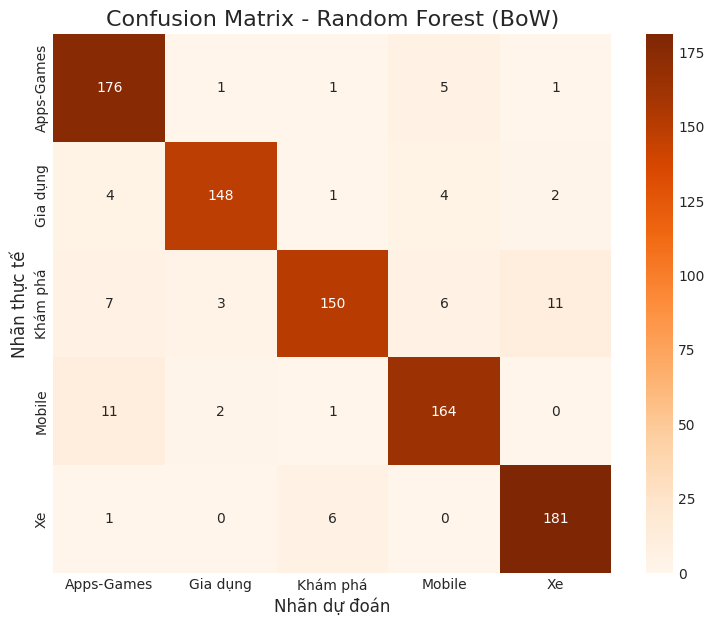

Đang lưu mô hình Random Forest
Đã lưu mô hình Scikit-learn vào: /content/drive/MyDrive/KKDL_Project/bow_model_random_forest.joblib

ĐÁNH GIÁ MÔ HÌNH: Logistic Regression (BoW)

Báo cáo phân loại cho Logistic Regression:

              precision    recall  f1-score   support

  Apps-Games       0.93      0.94      0.93       184
    Gia dụng       0.92      0.96      0.94       159
    Khám phá       0.95      0.88      0.91       177
      Mobile       0.93      0.93      0.93       178
          Xe       0.95      0.97      0.96       188

    accuracy                           0.93       886
   macro avg       0.93      0.93      0.93       886
weighted avg       0.93      0.93      0.93       886

Đã lưu biểu đồ vào: /content/drive/MyDrive/KKDL_Project/bow_confusion_matrix_logistic_regression.png


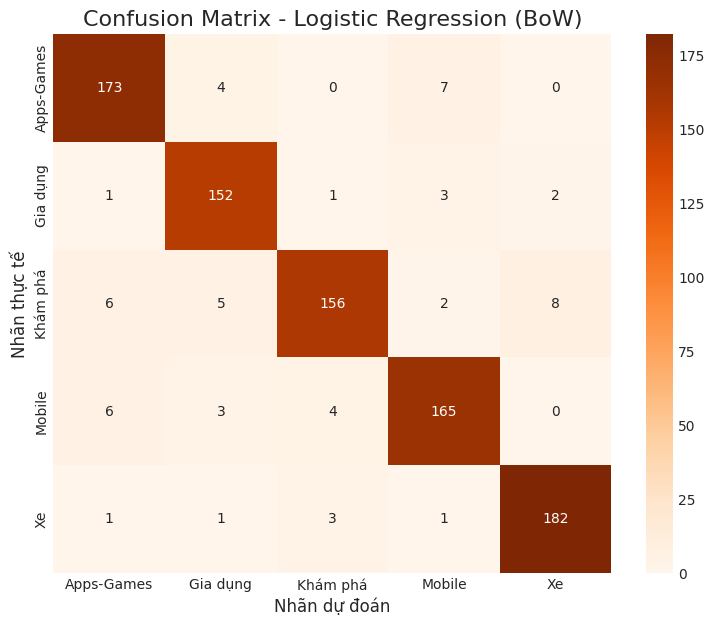

Đang lưu mô hình Logistic Regression
Đã lưu mô hình Scikit-learn vào: /content/drive/MyDrive/KKDL_Project/bow_model_logistic_regression.joblib

ĐÁNH GIÁ MÔ HÌNH: MLP (BoW)

Báo cáo phân loại cho MLP:

              precision    recall  f1-score   support

  Apps-Games       0.93      0.93      0.93       184
    Gia dụng       0.92      0.94      0.93       159
    Khám phá       0.96      0.89      0.92       177
      Mobile       0.95      0.94      0.95       178
          Xe       0.92      0.97      0.95       188

    accuracy                           0.94       886
   macro avg       0.94      0.94      0.94       886
weighted avg       0.94      0.94      0.94       886

Đã lưu biểu đồ vào: /content/drive/MyDrive/KKDL_Project/bow_confusion_matrix_mlp.png


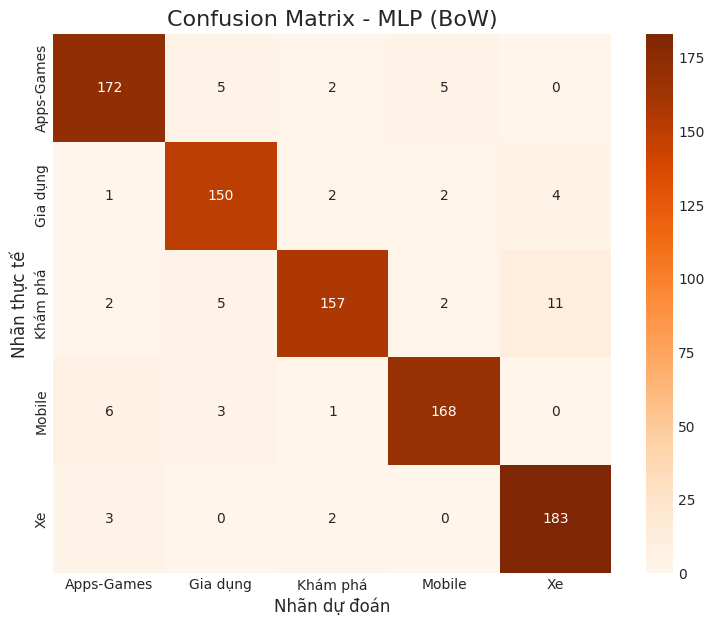

Đang lưu mô hình MLP
Đã lưu mô hình Keras vào: /content/drive/MyDrive/KKDL_Project/bow_model_mlp.keras

LƯU COUNT VECTORIZER

Đã lưu CountVectorizer vào: /content/drive/MyDrive/KKDL_Project/bow_vectorizer.joblib


Bảng so sánh các chỉ số của mô hình (Bag-of-Words):


,Accuracy,Precision,Recall,F1-score
MLP,0.936795,0.937148,0.936482,0.936389
Logistic Regression,0.934537,0.934490,0.934520,0.934141
SVM,0.931151,0.931163,0.931136,0.930921
Random Forest,0.924379,0.926653,0.923782,0.924308
Naive Bayes,0.914221,0.916563,0.913339,0.913628
KNN,0.825056,0.846831,0.824753,0.821053


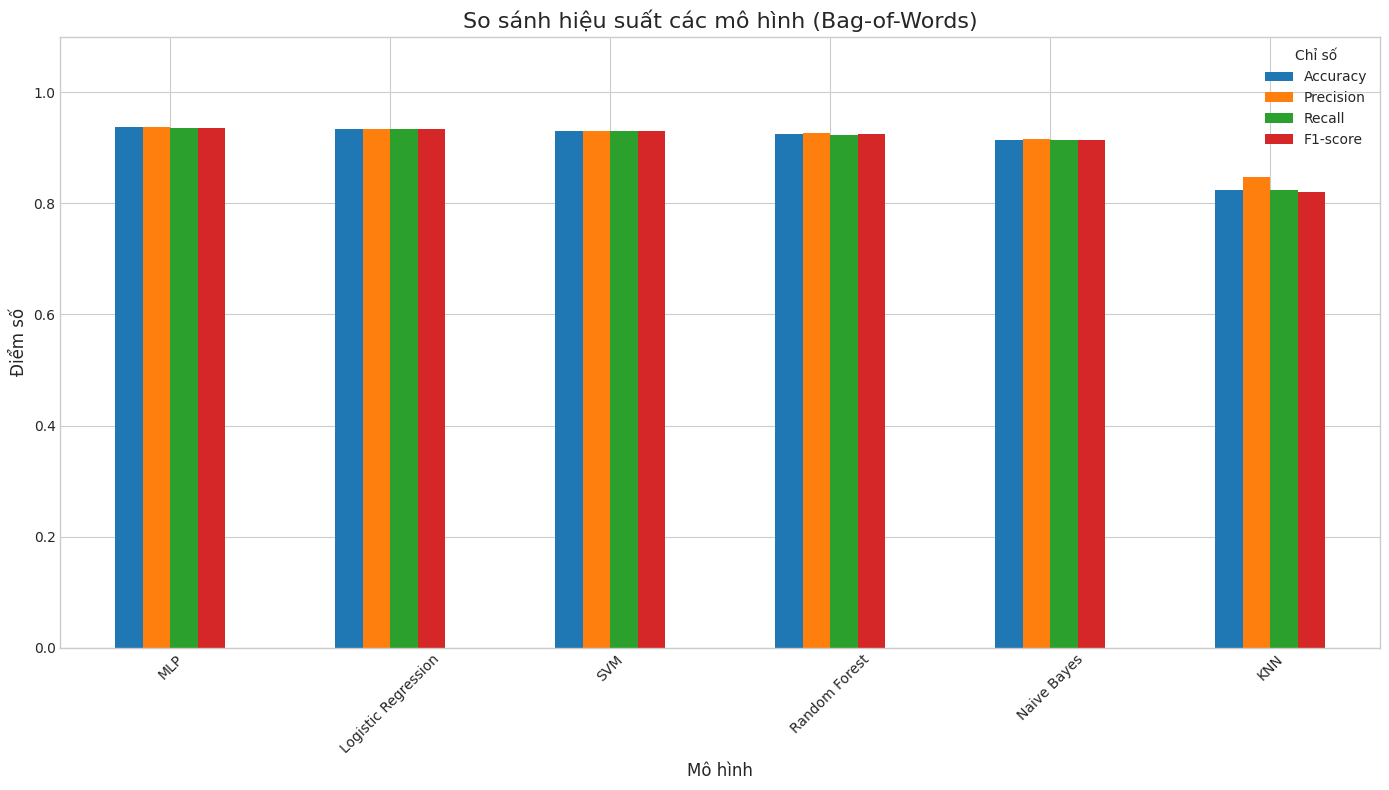


Mô hình tốt nhất (BoW) dựa trên Accuracy: 'MLP', với F1-score = 0.9368


In [30]:
bow_model_results = {}
save_dir = '/content/drive/MyDrive/KKDL_Project'

for model_name, model_instance in bow_models.items():
    print(f"\nĐÁNH GIÁ MÔ HÌNH: {model_name} (BoW)\n")
    if model_name in bow_predictions:
        current_predictions = bow_predictions[model_name]

        print(f"Báo cáo phân loại cho {model_name}:\n")
        report_bow = classification_report(y_test, current_predictions, target_names=label_encoder.classes_, output_dict=True)
        print(classification_report(y_test, current_predictions, target_names=label_encoder.classes_))

        bow_model_results[model_name] = {
            'Accuracy': report_bow['accuracy'],
            'Precision': report_bow['macro avg']['precision'],
            'Recall': report_bow['macro avg']['recall'],
            'F1-score': report_bow['macro avg']['f1-score']
        }

        cm_bow = confusion_matrix(y_test, current_predictions)
        plt.figure(figsize=(9, 7))
        sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Oranges',
                    xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
        plt.title(f'Confusion Matrix - {model_name} (BoW)', fontsize=16)
        plt.ylabel('Nhãn thực tế', fontsize=12)
        plt.xlabel('Nhãn dự đoán', fontsize=12)

        plot_save_path_bow = os.path.join(save_dir, f'bow_confusion_matrix_{model_name.lower().replace(" ", "_")}.png')
        plt.savefig(plot_save_path_bow)
        print(f"Đã lưu biểu đồ vào: {plot_save_path_bow}")
        plt.show()

        print(f"Đang lưu mô hình {model_name}")
        try:
            if model_name == 'MLP':
                model_save_path = os.path.join(save_dir, 'bow_model_mlp.keras')
                model_instance.save(model_save_path)
                print(f"Đã lưu mô hình Keras vào: {model_save_path}")
            else:
                model_save_path = os.path.join(save_dir, f'bow_model_{model_name.lower().replace(" ", "_")}.joblib')
                joblib.dump(model_instance, model_save_path)
                print(f"Đã lưu mô hình Scikit-learn vào: {model_save_path}")
        except Exception as e:
            print(f"Lỗi khi lưu mô hình {model_name}: {e}")

print(f"\nLƯU COUNT VECTORIZER\n")
try:
    vectorizer_save_path = os.path.join(save_dir, 'bow_vectorizer.joblib')
    joblib.dump(bow_vectorizer, vectorizer_save_path)
    print(f"Đã lưu CountVectorizer vào: {vectorizer_save_path}")
except Exception as e:
    print(f"Lỗi khi lưu CountVectorizer: {e}")

if bow_model_results:
    df_results_bow = pd.DataFrame.from_dict(bow_model_results, orient='index')
    df_results_bow = df_results_bow.sort_values(by='F1-score', ascending=False)

    print("\n\nBảng so sánh các chỉ số của mô hình (Bag-of-Words):")
    display(df_results_bow)

    df_results_bow.plot(kind='bar', figsize=(14, 8), rot=45)
    plt.title('So sánh hiệu suất các mô hình (Bag-of-Words)', fontsize=16)
    plt.ylabel('Điểm số', fontsize=12)
    plt.xlabel('Mô hình', fontsize=12)
    plt.ylim(0, 1.1)
    plt.legend(title='Chỉ số')
    plt.tight_layout()
    plt.show()

    best_model_name_bow = df_results_bow.index[0]
    best_model_f1_bow = df_results_bow.iloc[0]['F1-score']
    best_model_acc_bow = df_results_bow.iloc[0]['Accuracy']
    print(f"\nMô hình tốt nhất (BoW) dựa trên Accuracy: '{best_model_name_bow}', với F1-score = {best_model_acc_bow:.4f}")
else:
    print("\nKhông có kết quả để hiển thị.")